In [ ]:
import pandas as pd
import synapseclient
import synapseutils
import os
import configparser
from collections import OrderedDict

config_path = os.path.join(os.environ['HOME'], '.synapseConfig')
cfg = configparser.ConfigParser()
cfg.read(config_path)
syn_usr = cfg.get("authentication", "username")
syn_pwd = cfg.get("authentication", "password")
syn = synapseclient.login(email=syn_usr, password=syn_pwd, rememberMe=True)


sub2_synapse_id = 'syn10139539'
# if 'files' not in locals():
files = synapseutils.syncFromSynapse(syn, sub2_synapse_id)

data_dict = OrderedDict()
for fl in files:
    data_dict[fl.name] = pd.read_csv(fl.path, sep='\t')

# Read the data and summarize

In [1]:
import pandas as pd
import synapseclient
import synapseutils
import os
import configparser
from collections import OrderedDict

sub2_dir = '../data/sub2/'
bre_rnaseq = pd.read_csv(os.path.join(sub2_dir, 'retrospective_breast_rna_seq_sort_common_gene_15115.txt'), sep='\t')
bre_cna = pd.read_csv(os.path.join(sub2_dir, 'retrospective_breast_CNA_median_sort_common_gene_16884.txt'), sep='\t')
bre_proteome = pd.read_csv(os.path.join(sub2_dir, 'retrospective_breast_proteome_filtered.txt'), sep='\t')
print("Breast Cancer Data Summary ")
print("="*70)
print("RNASeq   : No.Samples : {}, No.Genes: {}".format(len(bre_rnaseq.columns)-1, len(bre_rnaseq)))
print("CNA      : No.Samples : {}, No.Genes: {}".format(len(bre_cna.columns)-1, len(bre_cna)))
print("Proteome : No.Samples : {}, No.Genes: {}".format(len(bre_proteome.columns)-1, len(bre_proteome)))
print("\n")
ova_rnaseq = pd.read_csv(os.path.join(sub2_dir, 'retrospective_ova_rna_seq_sort_common_gene_15632.txt'), sep='\t')
ova_cna = pd.read_csv(os.path.join(sub2_dir, 'retrospective_ova_CNA_sort_common_gene_11859.txt'), sep='\t')
ova_proteome = pd.read_csv(os.path.join(sub2_dir, 'retrospective_ova_proteome_filtered.txt'), sep='\t')

print("Overian Cancer Data Summary ")
print("="*70)
print("RNASeq   : No.Samples : {}, No.Gene: {}".format(len(ova_rnaseq.columns)-1, len(ova_rnaseq)))
print("CNA      : No.Samples : {}, No.Gene: {}".format(len(ova_cna.columns)-1, len(ova_cna)))
print("Proteome : No.Samples : {}, No.Gene: {}".format(len(ova_proteome.columns)-1, len(ova_proteome)))


Breast Cancer Data Summary 
RNASeq   : No.Samples : 77, No.Genes: 15115
CNA      : No.Samples : 77, No.Genes: 16884
Proteome : No.Samples : 105, No.Genes: 10597


Overian Cancer Data Summary 
RNASeq   : No.Samples : 294, No.Gene: 15632
CNA      : No.Samples : 559, No.Gene: 11859
Proteome : No.Samples : 174, No.Gene: 7163


## Filter for PAM50

In [2]:
# %%sh
# wget https://genome.unc.edu/pubsup/breastGEO/pam50_centroids.txt ../data/sub2/

In [7]:
# Filter criteria 
# 1. PAM 50 gene list
# 2. sample with QC status == pass
# 3. Protein shows up in >= 25% of the samples
import skfuzzy as fuzz

In [8]:
import pandas as pd
sample_cols = [c for c in bre_proteome.columns if c.startswith('TCGA')]

def filter_PAM50(df, PAM50, gene_col='Gene_ID'):
    return df[df[gene_col].apply(lambda x: x in PAM50)]

PAM50_df = pd.read_csv('../data/sub2/pam50_centroids.txt', sep='\t')
PAM50_df = PAM50_df.rename(columns={'Unnamed: 0': 'Gene_ID'})
PAM50 = set(PAM50_df['Gene_ID'])

PAM50_bre_rnaseq = filter_PAM50(bre_rnaseq, PAM50)
PAM50_bre_cna = filter_PAM50(bre_cna, PAM50)
PAM50_bre_proteome = filter_PAM50(bre_proteome, PAM50)

print("No.Genes before PAM50 filter: {}".format(str(len(bre_proteome['Gene_ID'].unique()))))
print("No.Genes after PAM50 filter: {}".format(str(len(PAM50_bre_proteome['Gene_ID'].unique()))))

No.Genes before PAM50 filter: 10597
No.Genes after PAM50 filter: 43


# Filter for Samples with QC status='pass'

In [9]:
suppl_data = pd.read_excel('../data/sub2/NIHMS778057-supplement-supp_table1.xlsx')

suppl_cols = [
    'TCGA ID', 'PAM50', 'ER Status', 'PR Status', 'HER2 Status', 'QC Status', 
    'Proteome Cluster (see Fig. 3b)',
    'Phosphoproteome Cluster (see Fig. 3b)',
    'Phosphoproteome-pathways cluster (see Fig. 3d)', 
    'GATA3 Mutation','PIK3CA Mutation', 'TP53 Mutation',
    'PIK3CA missense mutation in helical domain all tumors',
    'PIK3CA missense mutation in kinase domain all tumors',
    'TP53 Nonsense/Frameshift all tumors',
    'TP53 Missense mutation all tumors',
    'TP53 missense mutations in DNA binding domain all tumors'
]

QCfitered_samples = suppl_data[suppl_data['QC Status']=='pass']
print("No. Samples before QC filter: {}".format(str(len(suppl_data['TCGA ID'].unique()))))
print("No. Samples after QC filter: {}".format(str(len(QCfitered_samples['TCGA ID'].unique()))))

No. Samples before QC filter: 105
No. Samples after QC filter: 77


# Filter for gene showing up in more 25% sample

In [10]:
QCfiltered_bre_proteome = PAM50_bre_proteome[['Gene_ID'] + list(QCfitered_samples['TCGA ID'].values)]
total_samples = len(QCfitered_samples['TCGA ID'].unique())
appearance_count_by_gene = (
    pd.DataFrame(pd.notnull(QCfiltered_bre_proteome.set_index('Gene_ID')).astype(float).T.sum(), columns=['appearance'])
).reset_index()
QCfiltered_bre_proteome = QCfiltered_bre_proteome.merge(appearance_count_by_gene, on='Gene_ID', how='left')
QCfiltered_bre_proteome['percent_appearance'] = QCfiltered_bre_proteome['appearance']/total_samples
appearance_filtered = QCfiltered_bre_proteome[QCfiltered_bre_proteome['percent_appearance'] > 0.25]

print("No. Genes before appearance filter: {}".format( len(QCfiltered_bre_proteome['Gene_ID'].unique()) ) )
print("No. Genes before appearance filter: {}".format( len(appearance_filtered['Gene_ID'].unique()) ) )

No. Genes before appearance filter: 43
No. Genes before appearance filter: 39


In [11]:
genes_to_clusters = appearance_filtered['Gene_ID'].values
sample_to_clusters = QCfitered_samples['TCGA ID'].values
cna_to_cluster = (
    bre_cna
        # filter genes (rows)
        [bre_cna['Gene_ID'].apply(lambda x: x in genes_to_clusters)]
        # filter samples (columns)
        [['Gene_ID'] + list(sample_to_clusters)]
 )
                  
rnaseq_to_cluster = (
    bre_rnaseq
    [bre_rnaseq['Gene_ID'].apply(lambda x: x in genes_to_clusters)]
    [['Gene_ID'] + list(sample_to_clusters)]
)

proteome_to_cluster = (
    bre_proteome
    [bre_rnaseq['Gene_ID'].apply(lambda x: x in genes_to_clusters)]
    [['Gene_ID'] + list(sample_to_clusters)]                   
)


/Users/trimchala/miniconda/envs/synapse-env/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [164]:
def invert_and_append_columns(df, index_col=None, prefix=None, suffix=None):
    df = df.set_index(index_col).T if index_col is not None else df.T
    prefix = '' if (prefix is None) or len(prefix) == 0 else prefix + '_'
    suffix = '' if (suffix is None) or len(suffix) == 0 else '_' + suffix
    
    df.columns = prefix + df.columns + suffix
    return df

PAM50_rnaseq = invert_and_append_columns(PAM50_bre_rnaseq, index_col="Gene_ID", suffix='rnaseq')
PAM50_cna = invert_and_append_columns(PAM50_bre_cna, index_col="Gene_ID", suffix='cna')
PAM50_proteome = invert_and_append_columns(PAM50_bre_proteome, index_col="Gene_ID", suffix='proteome')
suppl_data = pd.read_excel('../data/sub2/NIHMS778057-supplement-supp_table1.xlsx')

suppl_cols = [
    'TCGA ID', 'PAM50', 'ER Status', 'PR Status', 'HER2 Status', 'QC Status', 
    'Proteome Cluster (see Fig. 3b)',
    'Phosphoproteome Cluster (see Fig. 3b)',
    'Phosphoproteome-pathways cluster (see Fig. 3d)', 
    'GATA3 Mutation','PIK3CA Mutation', 'TP53 Mutation',
    'PIK3CA missense mutation in helical domain all tumors',
    'PIK3CA missense mutation in kinase domain all tumors',
    'TP53 Nonsense/Frameshift all tumors',
    'TP53 Missense mutation all tumors',
    'TP53 missense mutations in DNA binding domain all tumors'
]

all_PAM50 = (
    PAM50_proteome
        .merge(PAM50_rnaseq, left_index=True, right_index=True, how='left')
        .merge(PAM50_cna, left_index=True, right_index=True, how='left')
        .merge(suppl_data[suppl_cols], left_index=True, right_on='TCGA ID')
)

final_cols = ['TCGA ID'] + list(
    PAM50_proteome.columns
    .append(PAM50_rnaseq.columns)
    .append(PAM50_cna.columns)
) + list(filter(lambda x: x != 'TCGA ID', suppl_cols))

all_PAM50 = all_PAM50[final_cols]
all_PAM50.to_csv('../data/sub2/merged_rnaseq_cna_proteome_filtered.csv', index=False)

In [160]:
import skfuzzy as fuzz
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler, MaxAbsScaler

def _impute(Xmat, return_imputer=False):
    imputer = Imputer(missing_values=np.nan,strategy="median",axis=0)
    if return_imputer: 
        return imputer.fit_transform(Xmat), imputer
    else: 
        return imputer.fit_transform(Xmat)

def _scale(Xmat, return_scaler=False): 
    scaler = MaxAbsScaler()
    if return_scaler: 
        return scaler.fit_transform(Xmat), scaler
    else: 
        return scaler.fit_transform(Xmat)

print("raw data shape:", rnaseq_to_cluster[breast_common_samples].as_matrix().shape)
imputed, imputer = _impute(rnaseq_to_cluster[breast_common_samples].as_matrix(), return_imputer=True)
print("imputed shape: ", imputed.shape)
scaled, scaler = _scale(imputed, return_scaler=True)
print("scaled shape:", scaled.shape)

raw data shape: (39, 77)
imputed shape:  (39, 77)
scaled shape: (39, 77)


## Try Bayesian Gaussian Mixture? 

In [159]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import itertools
n_components = 5
max_iter=5000
mean_prior=None
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
normed_dpgmm_ground_truth = BayesianGaussianMixture(
    n_components=n_components, covariance_type='full', mean_prior=mean_prior,
    weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(fuzzdata.shape[1]),
    init_params="kmeans", max_iter=max_iter, random_state=42, warm_start=True
).fit(fuzzdata)

normed_dpgmm_pred = normed_dpgmm_ground_truth.predict(fuzzdata)


## Hierarchical Clustering Of Filtered Data after Imputation and Scaling

In [76]:
# Further scoping down the analysis
transposed_rnaseq = PAM50_bre_rnaseq.set_index('Gene_ID').T
transposed_rnaseq.columns = 'rna-' + transposed_rnaseq.columns
transposed_cna = PAM50_bre_cna.set_index('Gene_ID').T
transposed_cna.columns = 'cna-' + transposed_cna.columns
transposed_proteome = PAM50_bre_proteome.set_index('Gene_ID').T
transposed_proteome.columns = 'proteome-' + transposed_proteome.columns

breast_common_samples = (
    transposed_rnaseq
        .merge(transposed_cna, left_index=True, right_index=True)
        .merge(transposed_proteome, left_index=True, right_index=True)
).index

Populating the interactive namespace from numpy and matplotlib


/Users/trimchala/miniconda/envs/synapse-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


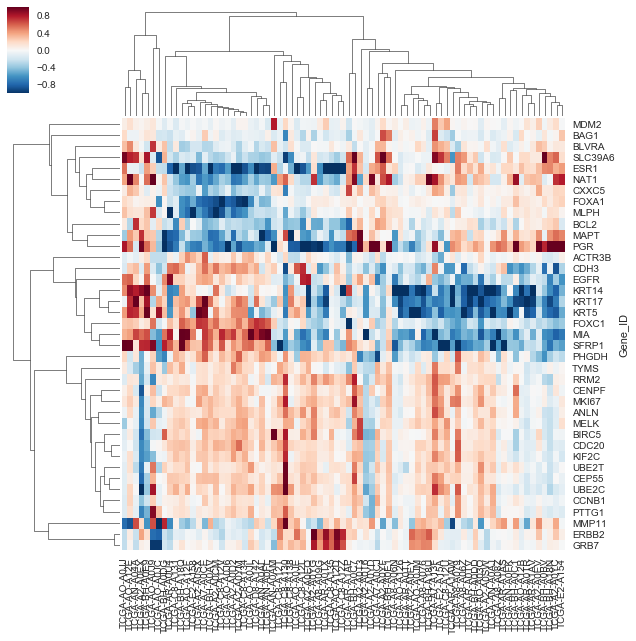

In [149]:
% pylab inline
import pandas as pd
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

gene_id = PAM50_bre_rnaseq["Gene_ID"]
lut = dict(zip(gene_id.unique(), "rbg"))
row_colors = gene_id.map(lut)
rna_imputed_and_scaled = _scale(_impute(rnaseq_to_cluster[breast_common_samples].as_matrix()))
rna_imputed_and_scaled_df = pd.DataFrame(rna_imputed_and_scaled, index=rnaseq_to_cluster.Gene_ID, columns = breast_common_samples)
clust_rnaseq = sns.clustermap(rna_imputed_and_scaled_df, metric="correlation")
plt.setp(clust_rnaseq.ax_heatmap.get_yticklabels(), rotation=0)
rnaseq_sample_clust, rnaseq_gene_clust = clust_rnaseq.dendrogram_col, clust_rnaseq.dendrogram_row

/Users/trimchala/miniconda/envs/synapse-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


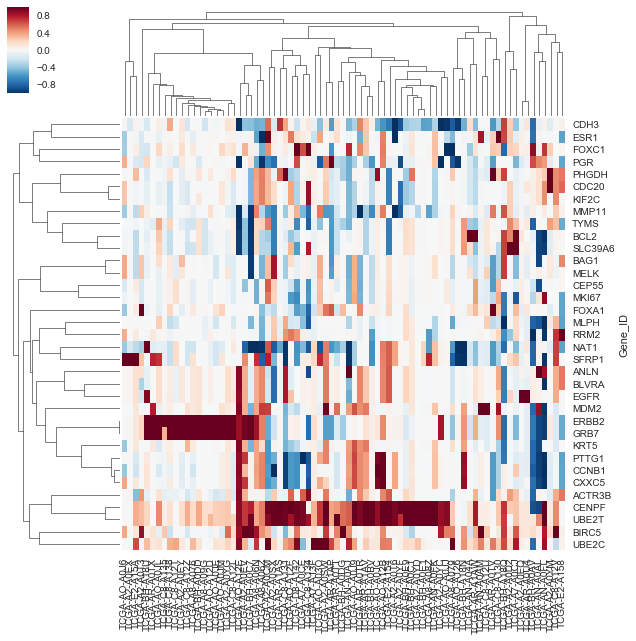

In [151]:
cna_imputed_and_scaled = _scale(_impute(cna_to_cluster[breast_common_samples].as_matrix()))
cna_imputed_and_scaled_df = pd.DataFrame(cna_imputed_and_scaled, index=cna_to_cluster.Gene_ID, columns = breast_common_samples)
clust_cna = sns.clustermap(cna_imputed_and_scaled_df, metric="correlation")
plt.setp(clust_cna.ax_heatmap.get_yticklabels(), rotation=0)
cna_sample_clust, cna_gene_clust = clust_cna.dendrogram_col, clust_cna.dendrogram_row

/Users/trimchala/miniconda/envs/synapse-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


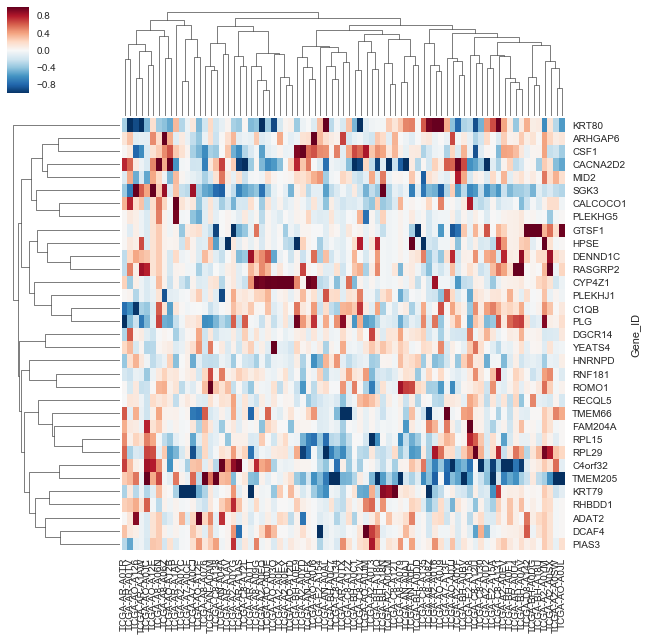

In [217]:
proteome_imputed_and_scaled = _scale(_impute(proteome_to_cluster[breast_common_samples].as_matrix()))
proteome_imputed_and_scaled_df = pd.DataFrame(proteome_imputed_and_scaled, index=proteome_to_cluster.Gene_ID, columns = breast_common_samples)
clust_proteome = sns.clustermap(proteome_imputed_and_scaled_df, metric="correlation")
plt.setp(clust_proteome.ax_heatmap.get_yticklabels(), rotation=0)
proteome_sample_clust, proteome_gene_clust = clust_proteome.dendrogram_col, clust_proteome.dendrogram_row

## Get Cluster Assignment out of Seaborn ClusterMap

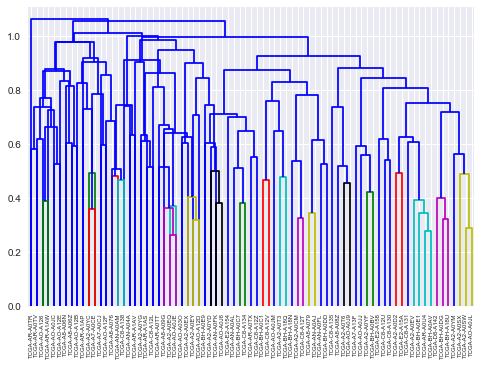

In [287]:
import scipy
from scipy.cluster import hierarchy
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_df = pd.DataFrame(den['ivl'], columns=['name'])
    cluster_df['cluster'] = ''
    for c, l in cluster_idxs.items():
        cluster_df.ix[l, 'cluster'] = c
                    
    return cluster_df

# Get cluster results from seaborn clustermap
proteome_imputed_and_scaled_df
threshold = 0.5
proteome_gene_dendrogram = hierarchy.dendrogram(clust_proteome.dendrogram_row.linkage,
                           labels = proteome_imputed_and_scaled_df.index,
                           color_threshold=threshold
                          )  
proteome_sample_dendrogram = hierarchy.dendrogram(clust_proteome.dendrogram_col.linkage,
                           labels = proteome_imputed_and_scaled_df.columns,
                           color_threshold=threshold
                          ) 
proteome_gene_clusters = get_cluster_classes(proteome_gene_dendrogram)
proteome_sample_clusters = get_cluster_classes(proteome_sample_dendrogram)

In [288]:
print("No Sample Clusters: {}".format(str(len(proteome_sample_clusters['cluster'].unique()))))
print("No Gene Clusters: {}".format(str(len(proteome_gene_clusters['cluster'].unique()))))

No Sample Clusters: 7
No Gene Clusters: 4


In [289]:
imputed_and_scaled = (
    invert_and_append_columns(cna_imputed_and_scaled_df, prefix='cna')
        .merge(invert_and_append_columns(rna_imputed_and_scaled_df, prefix='rnaseq'), left_index=True, right_index=True, how='left')
        .merge(invert_and_append_columns(proteome_imputed_and_scaled_df, prefix='proteome'), left_index=True, right_index=True, how='left')
        .merge(suppl_data[suppl_cols], left_index=True, right_on='TCGA ID')
)

final_imputed_cols = ['TCGA ID'] + list(filter(lambda x: x != 'TCGA ID', imputed_and_scaled))

imputed_and_scaled[final_imputed_cols].to_csv(
    '../data/sub2/merged_rnaseq_cna_proteome_imputed_scaled_filtered.csv', 
    index=False)

y_cols = ['TCGA ID'] + list(filter(lambda x: x.startswith('proteome'), imputed_and_scaled.columns))
x_cols = ['TCGA ID'] + [c for c in imputed_and_scaled.columns if c not in y_cols]

X = imputed_and_scaled[x_cols]
y = imputed_and_scaled[y_cols]

In [198]:
# Random Forest Classifier


array(['Basal', 'Her2', 'LumA', 'LumB'], dtype=object)

In [80]:
bre_rnaseq_35 = PAM50_bre_rnaseq[['Gene_ID'] + list(breast_common_samples)]
bre_cna_35 = PAM50_bre_cna[['Gene_ID'] + list(breast_common_samples)]
bre_proteome_35 = PAM50_bre_proteome[['Gene_ID'] + list(breast_common_samples)]

In [81]:
suppl_cols = [
    'TCGA ID', 'PAM50', 'ER Status', 'PR Status', 'HER2 Status', 'QC Status', 
    'Proteome Cluster (see Fig. 3b)',
    'Phosphoproteome Cluster (see Fig. 3b)',
    'Phosphoproteome-pathways cluster (see Fig. 3d)', 
    'GATA3 Mutation','PIK3CA Mutation', 'TP53 Mutation',
    'PIK3CA missense mutation in helical domain all tumors',
    'PIK3CA missense mutation in kinase domain all tumors',
    'TP53 Nonsense/Frameshift all tumors',
    'TP53 Missense mutation all tumors',
    'TP53 missense mutations in DNA binding domain all tumors'
]

In [82]:
paper_data = pd.read_excel('../data/sub2/NIHMS778057-supplement-supp_table1.xlsx')
paper_data[['Sample ID', 'QC Status']].groupby('QC Status').agg('count')

,Sample ID
QC Status,
fail,28
pass,77


# Comparing clusted results to the paper data

In [154]:
proteome_cols = [c for c in merged.columns if c.endswith('proteome')]
non_proteome_cols = [c for c in merged.columns if not c.endswith('proteome')]
y = merged[proteome_cols].as_matrix()
X = merged[non_proteome_cols].as_matrix()